# Raycast

In [1]:
#|default_exp raycast

In [2]:
#|export
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
from bayes3d._mkl.plotting import *

In [3]:
#|export
def solve(M, y):
    """Solves `Mx=y` for x."""
    a,b = M[0]
    c,d = M[1]
    det = a*d - b*c
    
    s = 1 /det *(  d*y[0] - b*y[1])
    t = 1 /det *(- c*y[0] + a*y[1])

    return s,t


def unit_vec(hd):
    return jnp.array([jnp.cos(hd), jnp.sin(hd)])


def create_angles(fov, num_a):
    return jnp.linspace(-fov/2, fov/2, num_a)

In [4]:
#|export
def line_intersect(x, dx, y, dy):
    v  = x - y
    M  = jnp.stack([-dx, dy], axis=1)
    s,t = solve(M,v)
    return s,t


In [5]:
#|export
def ray_intersect(x, phi, seg):
    dx = unit_vec(phi)
    seg = seg.reshape(2,2)
    y  = seg[0]
    dy = seg[1] - seg[0]
    s,t = line_intersect(x, dx, y, dy)
    h = (0 < s) & (0 <= t) & (t <= 1)
    return h, (s,t)

In [6]:
#|export
def seg_intersect(seg, seg_):
    seg = seg.reshape(2,2)
    seg_ = seg_.reshape(2,2)

    x  = seg[0]
    dx = seg[1] - seg[0]
    y  = seg_[0]
    dy = seg_[1] - seg_[0]

    s,t = line_intersect(x, dx, y, dy)
    h = (0 <= s) & (s <= 1) & (0 <= t) & (t <= 1)
    return h, (s,t)

-2.0725446 -0.0914761


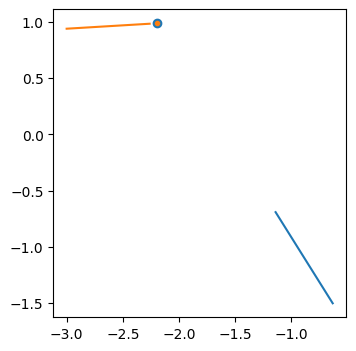

In [7]:
x,dx = np.random.randn(2,2)
y,dy = np.random.randn(2,2)

s,t = line_intersect(x,dx,y,dy)

print(s,t)

# -------------------
plt.figure(figsize=(4,4))
plt.gca().set_aspect(1)
plt.plot([x[0],x[0]+dx[0]],[x[1],x[1]+dx[1]])
plt.plot([y[0],y[0]+dy[0]],[y[1],y[1]+dy[1]])
plt.scatter(*(x + s*dx).T, marker="o")
plt.scatter(*(y + t*dy).T, marker=".");

In [8]:
#|export
def _cast_fori(x, theta, segs, zmax=jnp.inf):

    dx = unit_vec(theta)

    segs = segs.reshape(-1,2,2)
    ys  = segs[:,0]
    dys = segs[:,1] - segs[:,0]


    def body(i, zj):
        z,j = zj

        y  = jax.lax.dynamic_index_in_dim( ys, i, keepdims=False)
        dy = jax.lax.dynamic_index_in_dim(dys, i, keepdims=False)

        s,t = line_intersect(x,dx,y,dy)
        h = (0 < s) & (0 <= t) & (t <= 1)
        
        z = jnp.where(h, jnp.minimum(z,s), z)
        j = jnp.where(h, i, j)
        
        return (z,j)
    
    z,j = jax.lax.fori_loop(0, len(segs), body, (zmax,-1))

    return z, j

In [9]:
#|export
def _cast(x, theta, segs, zmax=jnp.inf):

    dx = unit_vec(theta)

    segs = segs.reshape(-1,2,2)
    ys  = segs[:,0]
    dys = segs[:,1] - segs[:,0]

    s,t = jax.vmap(line_intersect, (None,None,0,0))(x,dx,ys,dys)

    h = (0 < s) & (0 <= t) & (t <= 1)

    s_ = jnp.where( h == True, s, zmax)
    i = jnp.argmin(s_)

    return s_[i], i

In [10]:
#|export
def cast_fori(p, angles, segs):
    x  = p[:2]
    hd = p[2]
    return jax.vmap(_cast_fori, (None, 0, None))(x, angles+hd,segs)


jcast_fori = jax.jit(cast_fori)

In [11]:
#|export
def cast(p, angles, segs):
    x  = p[:2]
    hd = p[2]
    return jax.vmap(_cast, (None, 0, None))(x, angles+hd,segs)


jcast = jax.jit(cast)

2.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
371 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
420 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
364 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


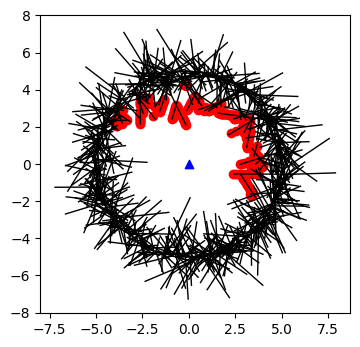

In [12]:
p = jnp.array([0,0,np.random.rand()*jnp.pi])
m = 1_000

_as = create_angles(jnp.pi, 360)
_s0 = np.random.randn(m,2)
_s0 = 5*_s0/np.linalg.norm(_s0, keepdims=True, axis=1)
_s1 = _s0 + 1*np.random.randn(m,2)
_segs = np.stack([_s0,_s1], axis=1)


%timeit -n 1 -r 1 cast(p, _as, _segs)
%timeit -n 1 -r 1 jcast(p, _as, _segs)

%timeit -n 1 -r 1 cast_fori(p, _as, _segs)
%timeit -n 1 -r 1 jcast_fori(p, _as, _segs)

z, i = cast(p, _as, _segs)



xs = p[:2] + z[:,None]*jax.vmap(unit_vec)(_as+p[2])




# -------------------
l = line_collection(_segs[:,0], _segs[:,1], np.tile((0,0,0,1),(len(_segs),1)), linewidth=1)
plt.figure(figsize=(4,4))
plt.gca().set_aspect(1)
plt.gca().add_collection(l)
# plt.scatter(*_segs[:,0].T, c=c, s=3)
# plt.scatter(*_segs[:,1].T, c=c, s=3)
plt.scatter(*xs.T, c="r")
plt.scatter(p[0],p[1], c="b", marker="^")

## Understanding memory usage

In [13]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)


In [17]:
from bayes3d._mkl.meshes import unpack_2d_env_data

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_ps = np.concatenate([_xs, _hds[:,None]], axis=1)
_as = create_angles(jnp.pi/2, 360);

In [69]:
v0 = jnp.array([*_xs[0], _hds[0]])
shape = (5,5,5)
res = (0.1,0.1,0.1)
vs = vector_grid(v0, shape, res, flat=True)
print(vs.shape)


jfunc = jax.vmap(lambda p: cast(p,_as,_segs))

%timeit -n 1 -r 1 jfunc(vs)

NameError: name '_xs' is not defined

## Segments

- https://google-research.github.io/self-organising-systems/2022/jax-raycast/

In [14]:
def dist_to_seg(x, s):
    s = s.reshape(2,2)
    x  = x - s[0]
    v  = s[1] - s[0]
    iv = jnp.array([-v[1], v[0]])

    iv = iv/jnp.linalg.norm(iv)

    d = jnp.where(jnp.dot(x, v) < 0,
                  jnp.linalg.norm(x),
                  jnp.where(jnp.dot(x, v) <= jnp.dot(v,v), 
                            jnp.abs(jnp.dot(x, iv)),
                            jnp.linalg.norm(x - v)))
    return d


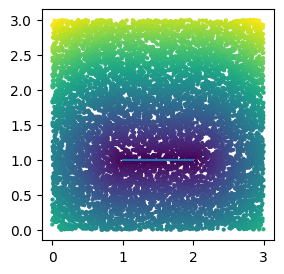

In [15]:
s = jnp.array([[1.,1.],[2.,1.]])
xs = 3*np.random.rand(10_000,2)

ds = jax.vmap(dist_to_seg, (0,None))(xs,s)

# ------------
plt.figure(figsize=(3,3))
plt.plot(s[:,0],s[:,1])
plt.scatter(*xs.T, c=ds, s=4);

In [16]:
def sdf(segs, x):
    return jnp.min(jax.vmap(dist_to_seg, (None, 0))(x, segs))


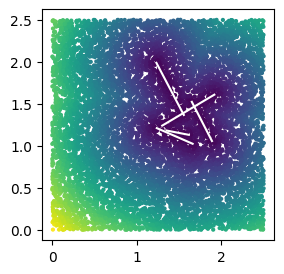

In [17]:
from functools import partial

ss = 1 + np.random.rand(5,2,2)
xs = 2.5*np.random.rand(10_000,2)

ds = jax.vmap(partial(sdf, ss))(xs)
ds = ds


# ------------
plt.figure(figsize=(3,3))
for s in ss:
    plt.plot(s[:,0],s[:,1], c="w")
plt.scatter(*xs.T, c=ds, s=4);

In [73]:
# def _sdf_cast(sdf, x, theta, zmax=3.0, n=50, eps=1e-2):
#     v = unit_vec(theta)
#     def f(_, z):
#         return z + sdf(x + z*v)
    
#     z = jax.lax.fori_loop(0, n, f, 0.0)
#     z = jnp.minimum(z,zmax)
#     return x + z*v



def _sdf_cast(sdf, x, theta, zmax=3.0, n=50, eps=1e-2):
    v = unit_vec(theta)
    def cont(z_d_and_i):
        z, d, i = z_d_and_i
        return (i <= n) & (d > eps)
    
    def f(z_d_i):
        z, _, i = z_d_i
        d = sdf(x + z*v)
        return z + d, d, i+1
    
    z,d,_ = jax.lax.while_loop(cont, f , (0.0,jnp.inf,1))
    z = jnp.minimum(z,zmax)
    
    return x + z*v

In [74]:
def bound_sdf(x):
    return jnp.min(jax.vmap(dist_to_seg, (None, 0))(x, _segs))


def sdf_cast(x, hd, thetas, ss, zmax=10.0, n=10, **kwargs):
    return jax.vmap(lambda theta: _sdf_cast(bound_sdf, x, hd + theta, zmax=zmax, n=n, **kwargs))(thetas)

jsdf_cast= jit(sdf_cast)

673 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


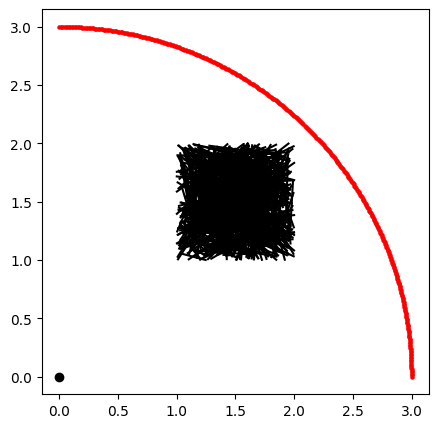

In [75]:
ss = 1 + np.random.rand(500,2,2)
x = jnp.zeros(2)
hd = jnp.pi/4
fov = jnp.pi/2
angles = jnp.linspace(fov/2, -fov/2, 360)


ys = jsdf_cast(x, hd, angles, ss, zmax=3.0, n=20, eps=1e-2)
%timeit -n 1 -r 1 jsdf_cast(x, hd, angles,ss, zmax=3.0, n=10, eps=1.).block_until_ready()

# ------------
plt.figure(figsize=(5,5))
for s in ss:
    plt.plot(s[:,0],s[:,1], c="k", zorder=1)
plt.scatter(*x, c="k")
plt.scatter(*ys.T, c="r", alpha=1., s=5, zorder=1)

In [76]:
from bayes3d._mkl.meshes import unpack_2d_env_data

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_ps = np.concatenate([_xs, _hds[:,None]], axis=1)
_as = create_angles(jnp.pi/2, 360);

In [77]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)


In [80]:
v0 = jnp.array([*_xs[0], _hds[0]])
shape = (10,10,10)
res = (0.1,0.1,0.1)
vs = vector_grid(v0, shape, res, flat=True)
print(vs.shape)

(1000, 3)


In [81]:
cast = jax.vmap(lambda p: sdf_cast(p[:2], p[2], _as, _segs, zmax=20.0, n=20, eps=1e-2))
jcast = jit(cast)

cast(vs)
jcast(vs)

%timeit -n 1 -r 1  cast(vs);
%timeit -n 1 -r 1  jcast(vs);

487 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
127 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:

%timeit -n 1 -r 1  cast(vs);
%timeit -n 1 -r 1  jcast(vs);

473 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
127 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
